In [1]:
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
from random import randint


In [2]:
image_path = "../data/new_lego_colmap/images/r"
image_paths = []
for i in range (100):
    image_paths.append(image_path +"_"+ str(i) + ".png")

In [3]:
file_images_txt = open("../data/new_lego_colmap/sparse/0/images.txt", 'r')


In [4]:
class K_means :
    def __init__(self, k, max_iters=400):
        self.k = k
        self.max_iters = max_iters
        self.cluster = []
        self.i = 0
        self.resample = 32
        self.data = []
        self.data_paths = []
        
        
    def euclidean_distance(self, a, b):
        distance = 0
        for i in range(len(a)):
            distance += (a[i]-b[i])**2
        return distance**0.5
    
    def chi2_distance(self,a, b):
        eps = 1e-10
        sum = 0
        for i in range(len(a)):
            sum += ((a[i]-b[i])**2)/(a[i]+b[i]+eps)
        return 0.5 * sum
                
    def read_image(self, im):
        try:
            img = Image.open(im)

            # Resize to consistent size
            img = img.resize((self.resample, self.resample))

            # Convert to grayscale and flatten
            arr = np.asarray(img.convert("L")).flatten().astype(np.float32)

            # Normalize to [0,1]
            arr /= 255.0

            return arr.tolist()

        except Exception as e:
            print(f"Error reading {im}: {e}")
            return None

    def generate_k_means(self):
        final_means = []
        for c in range(self.k):
            partial_mean = []
            for i in range(len(self.data[0])):
                s = 0
                t = 0
                for j in range(len(self.data)):
                    if self.cluster[j] == c:
                        s += self.data[j][i]
                        t += 1
                if t > 0:
                    partial_mean.append(s/t)
                else:
                    # avoid empty means → re-seed with random point
                    idx = np.random.randint(0, len(self.data))
                    partial_mean.append(self.data[idx][i])
            final_means.append(partial_mean)
        return final_means
    
    def assign_clusters(self, means):
        # update cluster assignment for every data point
        for i in range(len(self.data)):
            d_min = float('inf')
            idx = 0
            for c in range(self.k):
                d = self.chi2_distance(self.data[i], means[c])
                if d < d_min:
                    d_min = d
                    idx = c
            self.cluster[i] = idx

    def generate_clusters(self, means):
        clusters = [[] for _ in range(self.k)]
        for i in range(len(self.data)):
            clusters[self.cluster[i]].append(self.data_paths[i])
        return clusters
    
    def open_data_paths(self, paths):
        self.data_paths = []
        self.data = []
        for p in paths:
            im = self.read_image(p)
            if im is not None:
                self.data.append(im)
                self.data_paths.append(p)
        
        # initialize cluster assignments randomly
        self.cluster = np.random.randint(0, self.k, len(self.data)).tolist()

    def fit(self):
        for _ in range(self.max_iters):
            means = self.generate_k_means()
            self.assign_clusters(means)

        return self.generate_k_means(), self.generate_clusters(means)


In [5]:
kmean_images = K_means(k=12)
kmean_images.open_data_paths(image_paths)

_,clusters = kmean_images.fit()   # <-- THIS runs K-means properly



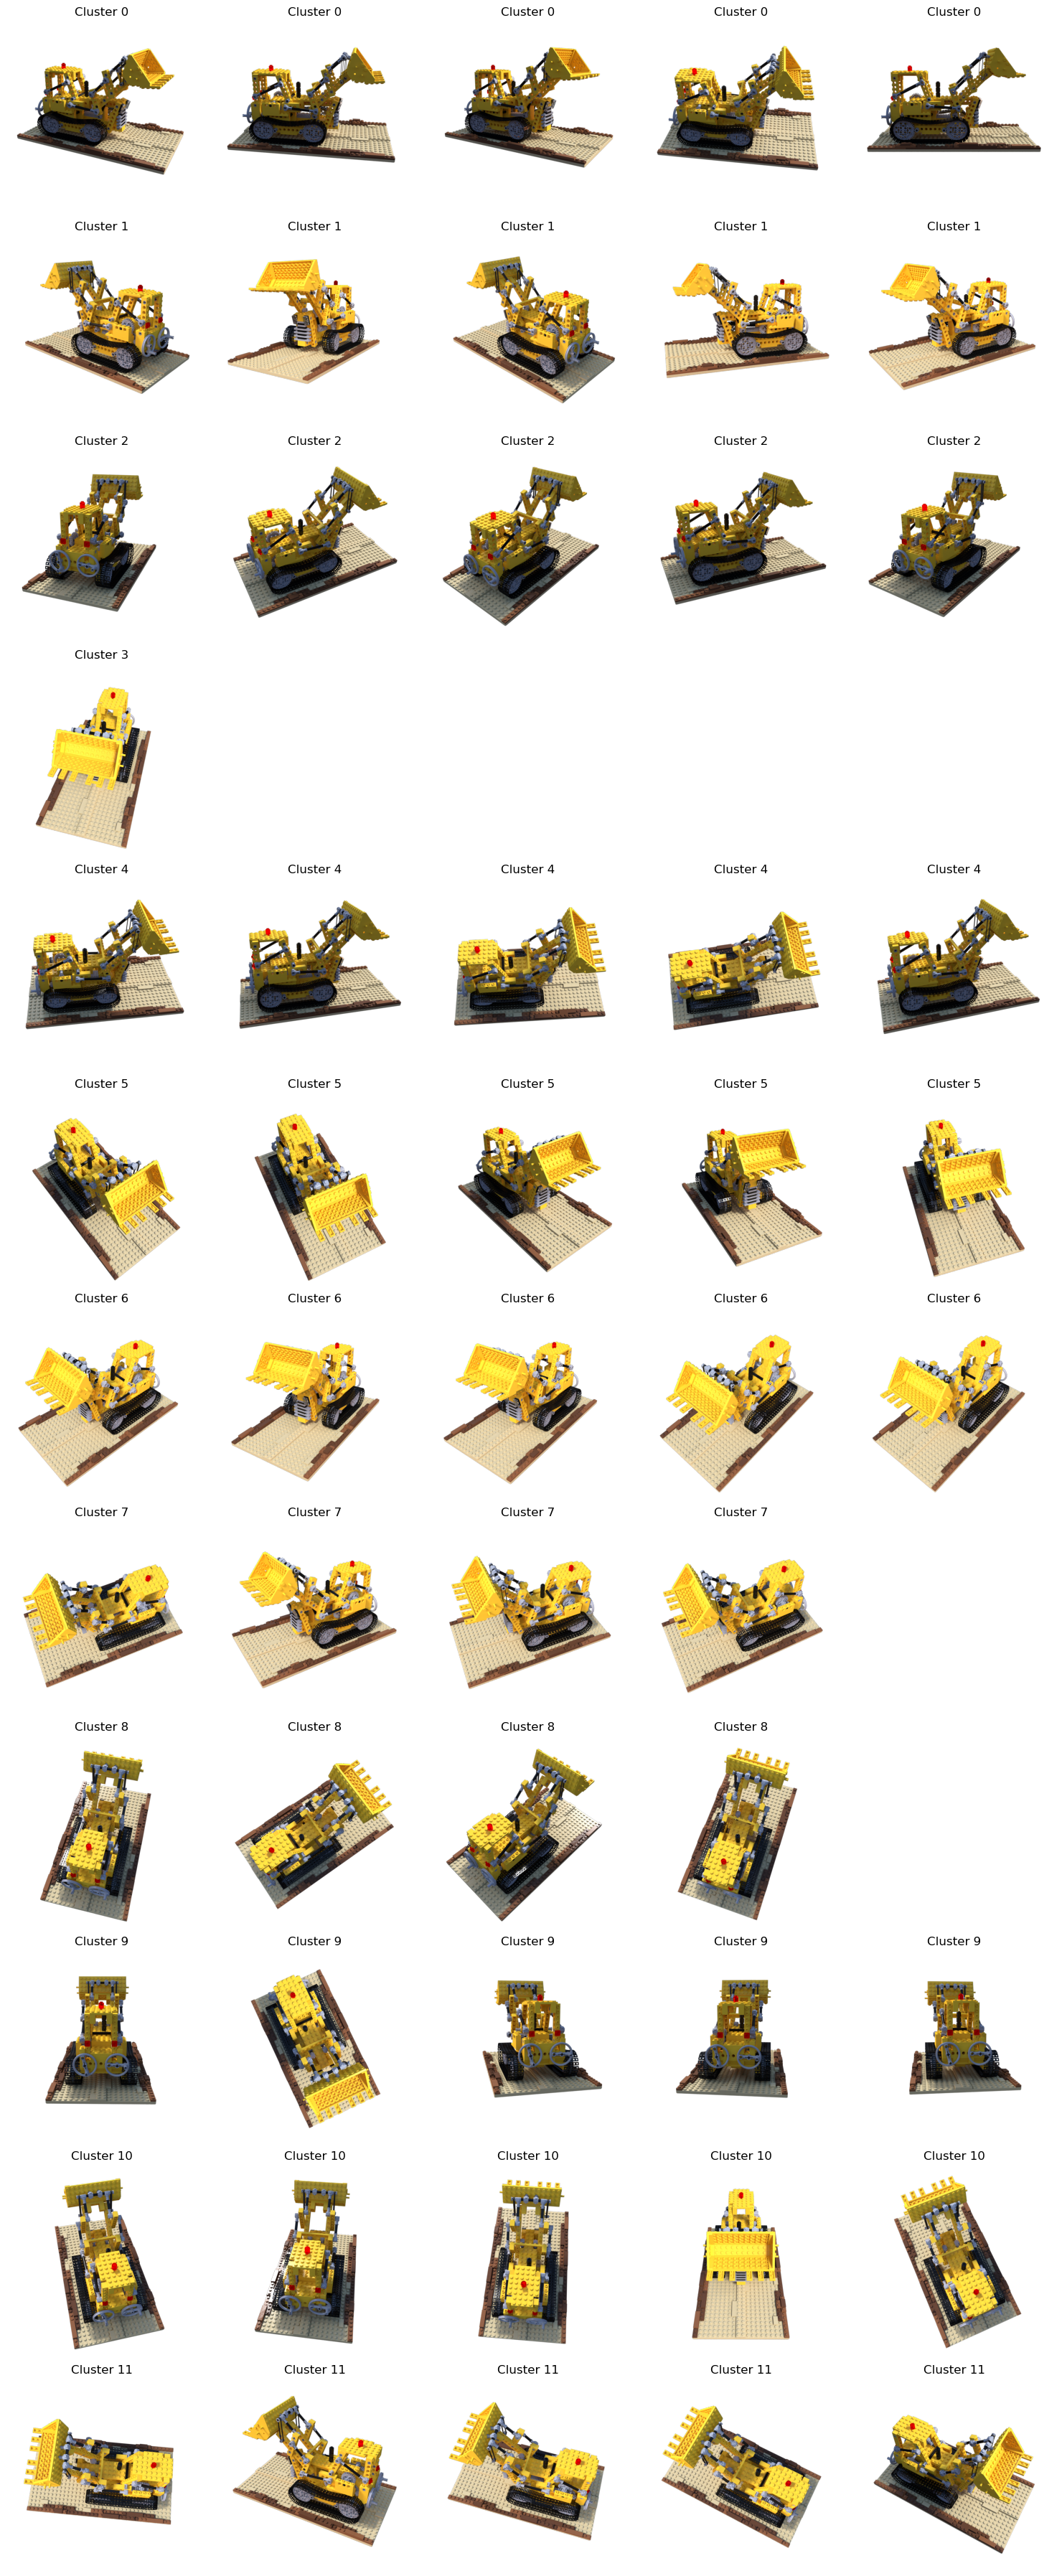

In [6]:
#open 3 images from each cluster in a grid and display them
fig, axs = plt.subplots(kmean_images.k, 5, figsize=(15, 3*kmean_images.k))
for i in range(kmean_images.k):
    for j in range(5):
        if j < len(clusters[i]):
            img = Image.open(clusters[i][j])
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Cluster {i}")
        else:
            axs[i, j].axis('off')
plt.tight_layout()
plt.show()

Representative image for cluster 0: ../data/new_lego_colmap/images/r_8.png
Representative image for cluster 1: ../data/new_lego_colmap/images/r_17.png
Representative image for cluster 2: ../data/new_lego_colmap/images/r_96.png
Representative image for cluster 3: ../data/new_lego_colmap/images/r_84.png
Representative image for cluster 4: ../data/new_lego_colmap/images/r_5.png
Representative image for cluster 5: ../data/new_lego_colmap/images/r_92.png
Representative image for cluster 6: ../data/new_lego_colmap/images/r_36.png
Representative image for cluster 7: ../data/new_lego_colmap/images/r_80.png
Representative image for cluster 8: ../data/new_lego_colmap/images/r_82.png
Representative image for cluster 9: ../data/new_lego_colmap/images/r_0.png
Representative image for cluster 10: ../data/new_lego_colmap/images/r_79.png
Representative image for cluster 11: ../data/new_lego_colmap/images/r_77.png


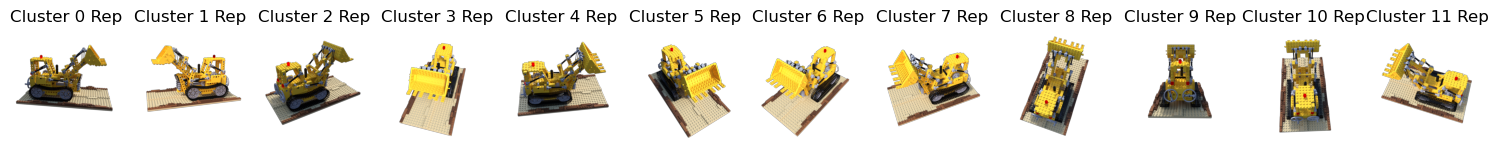

In [7]:
#select 1 representative image from each cluster and save it
rep_images = []
for i in range(kmean_images.k):
    min_delta_to_mean = float('inf')
    representative_image = None
    for img_path in clusters[i]:
        img_data = kmean_images.read_image(img_path)
        delta = kmean_images.chi2_distance(img_data, kmean_images.generate_k_means()[i])
        if delta < min_delta_to_mean:
            min_delta_to_mean = delta
            representative_image = img_path
    if representative_image is not None:
        rep_images.append(representative_image)
        print(f"Representative image for cluster {i}: {representative_image}")

#open 3 images from each cluster in a grid and display them
fig, axs = plt.subplots(1, len(rep_images), figsize=(15, 3))
for i in range(len(rep_images)):
    img = Image.open(rep_images[i])
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Cluster {i} Rep")
plt.tight_layout()
plt.show()

In [8]:
def select_n_representative_images(clusters, n=1):
    rep_images = []
    for i in range(len(clusters)):
        cluster_images = clusters[i]
        selected_images = []
        if len(cluster_images) <= n:
            selected_images = cluster_images
        else:
            selected_indices = set()
            while len(selected_indices) < n:
                idx = randint(0, len(cluster_images) - 1)
                selected_indices.add(idx)
            selected_images = [cluster_images[idx] for idx in selected_indices]
        rep_images.append(selected_images)
    return rep_images

## Modifying colmap to prune images

In [17]:
import os
import shutil
import subprocess

In [27]:
print("Selected representative images per cluster:")
print(rep_images)
names = []
for img_path in rep_images:
    img_path_split = img_path.split("/")
    names.append(img_path_split[-1])
print (names)

Selected representative images per cluster:
['../data/new_lego_colmap/images/r_8.png', '../data/new_lego_colmap/images/r_17.png', '../data/new_lego_colmap/images/r_96.png', '../data/new_lego_colmap/images/r_84.png', '../data/new_lego_colmap/images/r_5.png', '../data/new_lego_colmap/images/r_92.png', '../data/new_lego_colmap/images/r_36.png', '../data/new_lego_colmap/images/r_80.png', '../data/new_lego_colmap/images/r_82.png', '../data/new_lego_colmap/images/r_0.png', '../data/new_lego_colmap/images/r_79.png', '../data/new_lego_colmap/images/r_77.png']
['r_8.png', 'r_17.png', 'r_96.png', 'r_84.png', 'r_5.png', 'r_92.png', 'r_36.png', 'r_80.png', 'r_82.png', 'r_0.png', 'r_79.png', 'r_77.png']


In [28]:

SRC = "../data/new_lego_colmap"
DST = "../data/lego_colmap_small"
MODEL = "sparse/0"


# --------------------------------------------------
# Copy dataset
# --------------------------------------------------
if os.path.exists(DST):
    raise RuntimeError(f"{DST} already exists")

print("Copying dataset...")
shutil.copytree(SRC, DST)

# --------------------------------------------------
# Convert model to TXT
# --------------------------------------------------
txt_model = os.path.join(DST, "sparse/0_txt")
bin_model = os.path.join(DST, MODEL)

os.makedirs(txt_model, exist_ok=True)

subprocess.run([
    "colmap", "model_converter",
    "--input_path", bin_model,
    "--output_path", txt_model,
    "--output_type", "TXT"
], check=True)

# --------------------------------------------------
# Prune TXT model
# --------------------------------------------------
pruned_txt = os.path.join(DST, "sparse/0_pruned_txt")
os.makedirs(pruned_txt, exist_ok=True)

keep_names = set(names)
kept_image_ids = set()

# ---------- images.txt ----------
images_out = []
with open(os.path.join(txt_model, "images.txt")) as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i]
    if line.startswith("#") or line.strip() == "":
        images_out.append(line)
        i += 1
        continue

    elems = line.split()
    image_id = int(elems[0])
    image_name = elems[-1]

    points_line = lines[i + 1]

    if image_name in keep_names:
        kept_image_ids.add(image_id)
        images_out.append(line)
        images_out.append(points_line)

    i += 2

with open(os.path.join(pruned_txt, "images.txt"), "w") as f:
    f.writelines(images_out)

print(f"Kept {len(kept_image_ids)} images")

# ---------- cameras.txt ----------
shutil.copy(
    os.path.join(txt_model, "cameras.txt"),
    os.path.join(pruned_txt, "cameras.txt")
)

# ---------- points3D.txt ----------
points_out = []
with open(os.path.join(txt_model, "points3D.txt")) as f:
    for line in f:
        if line.startswith("#") or line.strip() == "":
            points_out.append(line)
            continue

        elems = line.split()
        track = elems[8:]

        new_track = []
        for j in range(0, len(track), 2):
            img_id = int(track[j])
            kp_id = track[j + 1]
            if img_id in kept_image_ids:
                new_track.extend([str(img_id), kp_id])

        if len(new_track) >= 2:
            elems = elems[:8] + new_track
            points_out.append(" ".join(elems) + "\n")

with open(os.path.join(pruned_txt, "points3D.txt"), "w") as f:
    f.writelines(points_out)


Copying dataset...
Kept 12 images


In [29]:

# --------------------------------------------------
# Convert back to BIN
# --------------------------------------------------
ppruned_bin = os.path.join(DST, MODEL)

if os.path.exists(pruned_bin):
    shutil.rmtree(pruned_bin)

os.makedirs(pruned_bin, exist_ok=True)

subprocess.run([
    "colmap", "model_converter",
    "--input_path", pruned_txt,
    "--output_path", pruned_bin,
    "--output_type", "BIN"
], check=True)

print("Pruned COLMAP model written successfully.")



Pruned COLMAP model written successfully.


In [30]:
# --------------------------------------------------
# Prune image files (SAFE)
# --------------------------------------------------
img_root = os.path.join(DST, "images")

if not os.path.isdir(img_root):
    print("No images directory found, skipping image pruning.")
else:
    keep_names = set(os.path.basename(x) for x in rep_images)

    removed = 0
    kept = 0

    for root, _, files in os.walk(img_root):
        for fname in files:
            fpath = os.path.join(root, fname)

            # Only touch image files
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                continue

            if fname in keep_names:
                kept += 1
            else:
                os.remove(fpath)
                removed += 1

    print(f"Image pruning complete: kept {kept}, removed {removed}")


Image pruning complete: kept 12, removed 88


## Brouillon

In [9]:
def write_line_to_file(file, line):
    file.write(line + "\n")

In [ ]:
def select_images_index(indices,file_selected_images, n_images):
    #images.txt is structured as follows:
    ## Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
# Number of images: 100, mean observations per image: 607.00999999999999
    write_details = False
    mean_obs_num = 0
    file_images_txt = open("../data/new_lego_colmap/sparse/0/images.txt", 'r')
    lines = file_images_txt.readlines()
    print(len(lines))
    lines_new = []
    k = 1
    for i in range(4, len(lines)):
        if (i%2) == 1:
            if write_details:
                lines_new.append(lines[i].strip())
                mean_obs_num += (len(lines[i].strip().split())//3)/n_images
        else :
            write_details = False
            parts = lines[i].strip().split()
            image_name = parts[9]
            print(image_name[2:-4])
            #remove r_ and .png to get the image id
            image_id = int(image_name[2:-4])
            if image_id in indices:
                write_details = True
                #replace the old index with the new one (first word of the line)
                l = lines[i].strip().split()
                l[0] = str(k)
                k += 1
                lines_new.append(" ".join(l))
    print(lines_new)
    
    write_line_to_file(file_selected_images,"# Image list with two lines of data per image:")
    write_line_to_file(file_selected_images,"# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME")

    for line in lines_new:
        write_line_to_file(file_selected_images,line)

In [11]:
#rewrite images.txt with only the representative images
#create new folder in data
import os
new_colmap_path = "../data/colmap_lego_small/"
if not os.path.exists(new_colmap_path):
    os.makedirs(new_colmap_path)

In [12]:
#save representative images in the new folder
for img_path in rep_images:
    if img_path is None: continue
    img = Image.open(img_path)
    img_name = os.path.basename(img_path)
    img.save(os.path.join(new_colmap_path, img_name))

In [ ]:
#create folder sparse in the new colmap folder
new_sparse_path = os.path.join(new_colmap_path, "sparse/0")
if not os.path.exists(new_sparse_path):
    os.makedirs(new_sparse_path)

#write new images.txt
file_selected_images = open(os.path.join(new_sparse_path, "images.txt"), 'w')
#select images indexes
selected_image_indices = set()
for img_path in rep_images:
    image_idx = img_path.split("_")[-1].split(".")[0]
    selected_image_indices.add(int(image_idx))
    print(f"Selected image index: {image_idx}")
   

select_images_index(selected_image_indices, file_selected_images, len(selected_image_indices))

In [14]:
path = "../data/colmap_lego_small/sparse/0/images.txt"

with open(path) as f:
    lines = f.readlines()

for i in range(2, len(lines), 2):
    line = lines[i].strip()
    if not line:
        print("Empty metadata line at", i+1)
        break

    parts = line.split()

    try:
        int(parts[0])      # IMAGE_ID
        int(parts[8])      # CAMERA_ID
    except Exception:
        print("❌ INVALID LINE", i+1)
        print(line)
        break
else:
    print("✅ No IMAGE_ID / CAMERA_ID errors found")

✅ No IMAGE_ID / CAMERA_ID errors found


## Creating a pipeline to select from the computed clusters

In [15]:
def select_n_representative_images(clusters, n=1, threshold=1.0):
    rep_images_per_cluster = []

    # Precompute cluster centers
    cluster_centers = kmean_images.generate_k_means()

    for i in range(kmean_images.k):
        cluster_reps = []

        # Handle empty cluster or None cluster center
        if not clusters[i] or cluster_centers[i] is None:
            print(f"Cluster {i} is empty or has no center.")
            rep_images_per_cluster.append(cluster_reps)
            continue

        cluster_center = cluster_centers[i]
        deltas = []

        for img_path in clusters[i]:
            img_data = kmean_images.read_image(img_path)
            if img_data is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            delta = kmean_images.chi2_distance(img_data, cluster_center)
            if delta <= threshold:
                deltas.append((delta, img_path))

        deltas.sort(key=lambda x: x[0])
        selected = [img_path for _, img_path in deltas[:n]]
        cluster_reps.extend(selected)

        rep_images_per_cluster.append(cluster_reps)
        print(f"Representative images for cluster {i}: {cluster_reps}")

    return rep_images_per_cluster

select_n_representative_images(clusters, n=5) 

Representative images for cluster 0: []
Representative images for cluster 1: []
Representative images for cluster 2: []
Representative images for cluster 3: ['../data/new_lego_colmap/images/r_84.png']
Representative images for cluster 4: []
Representative images for cluster 5: []
Representative images for cluster 6: []
Representative images for cluster 7: []
Representative images for cluster 8: []
Representative images for cluster 9: []
Representative images for cluster 10: []
Representative images for cluster 11: []


[[],
 [],
 [],
 ['../data/new_lego_colmap/images/r_84.png'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]